<a href="https://colab.research.google.com/github/XiaoWei-xw11/Maybank-stock-price-forecasting-/blob/main/FYP_2__MAYBANK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL

In [ ]:
stockprice = pd.read_csv('/content/stockprice_1155_daily_2015-2024.csv')
opr = pd.read_csv('//content/OPR_2015-2025.csv')
cpi = pd.read_csv('/content/CPI_MONTHLY_2015-2024.csv')
exchange = pd.read_csv('/content/exchange-rates_2015-2025_daily.csv')
ipi = pd.read_csv('/content/IPI_MONTHLY_2015-2024.csv')

In [ ]:
# If 'Date' is the index, reset it to make it a column
if stockprice.index.name == 'Date':
    stockprice = stockprice.reset_index()

# Convert 'Date' column to datetime objects
stockprice['Date'] = pd.to_datetime(stockprice['Date'], errors='coerce')

# Drop rows where 'Date' is NaT before setting as index
stockprice.dropna(subset=['Date'], inplace=True)

# Set 'Date' as the index
stockprice.set_index('Date', inplace=True)

# Resample to monthly frequency and get the last price of the month
stockprice_monthly = stockprice.resample('ME').last()

# Display the monthly stock price data
print("Monthly Stock Price Data:")
display(stockprice_monthly.head())

Monthly Stock Price Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-31,8.70,8.80,8.64,8.72,4.35,12167300
2015-02-28,9.17,9.25,9.13,9.20,4.59,13166000
2015-03-31,9.30,9.36,9.29,9.33,4.66,11373500
2015-04-30,9.30,9.34,9.21,9.21,4.77,12107600
2015-05-31,9.08,9.15,9.03,9.03,4.67,12535300


In [ ]:
# Convert 'date' column to datetime safely
cpi['date'] = pd.to_datetime(cpi['date'], format='%d/%m/%Y', errors='coerce')

# Drop any rows where date conversion failed (NaT values)
cpi = cpi.dropna(subset=['date'])

cpi = cpi[['date', 'index']]
# Set date as index
cpi.set_index('date', inplace=True)

# Resample to month-end ('M' = month end)
cpi_monthly = cpi.resample('ME').last()

# Rename the 'index' column to 'CPI'
cpi_monthly.rename(columns={'index': 'CPI'}, inplace=True)

# Display
print("Monthly CPI Data (End of Month):")
display(cpi_monthly.head())

Monthly CPI Data (End of Month):


,CPI
date,
2015-01-31,110.6
2015-02-28,109.9
2015-03-31,110.9
2015-04-30,111.9
2015-05-31,112.3


In [ ]:
opr = pd.read_csv('/content/OPR_2015-2025.csv')

# Reset index to make 'Date' a column again (if it was the index)
opr = opr.reset_index(drop=True) # Dropping existing 'index' if any from previous resets

# Convert 'Date' column to datetime objects
opr['Date'] = pd.to_datetime(opr['Date'], dayfirst=True)

# Set 'Date' as index
opr.set_index('Date', inplace=True)

# Resample to month-end ('M') and take the last value of each month, then forward-fill NaNs
opr_monthly = opr.resample('ME').last().ffill()
opr_monthly.rename(columns={'Rate': 'OPR'}, inplace=True)
# Display the monthly opr rate data
print("Monthly opr Rate Data (End of Month) after forward-fill:")
display(opr_monthly.head())

Monthly opr Rate Data (End of Month) after forward-fill:


,OPR
Date,
2015-01-31,3.25
2015-02-28,3.25
2015-03-31,3.25
2015-04-30,3.25
2015-05-31,3.25


In [ ]:
# Reset the index to make 'Date' a column again
exchange = exchange.reset_index()

# Convert 'Date' column to datetime objects for resampling
exchange['Date'] = pd.to_datetime(exchange['Date'], format='%d/%m/%Y')

# Set 'Date' as the index
exchange.set_index('Date', inplace=True)

# Resample to monthly frequency and calculate the mean
exchange_monthly = exchange.resample('ME').mean()

# Display the monthly exchange rate data
print("Monthly Exchange Rate Data:")
display(exchange_monthly.head())

Monthly Exchange Rate Data:


,index,USD
Date,,
2015-01-31,10.0,3.584810
2015-02-28,28.5,3.591562
2015-03-31,47.5,3.680636
2015-04-30,69.5,3.634159
2015-05-31,90.0,3.604500


In [ ]:
ipi = pd.read_csv('/content/IPI_MONTHLY_2015-2024.csv')

# Reset index to make 'Date' a column again (if it was the index)
ipi = ipi.reset_index(drop=True) # Dropping existing 'index' if any from previous resets

# Convert 'Date' column to datetime objects
ipi['date'] = pd.to_datetime(ipi['date'], dayfirst=True)

# Set 'Date' as index
ipi.set_index('date', inplace=True)


# Resample to month-end ('M') and take the last value of each month, then forward-fill NaNs
ipi_monthly = ipi.resample('ME').last().ffill()
ipi_monthly.rename(columns={'index_sa': 'IPI_sa'}, inplace=True)
# Display the monthly opr rate data
print("Monthly ipi Rate Data (End of Month) after forward-fill:")
display(ipi_monthly.head())

Monthly ipi Rate Data (End of Month) after forward-fill:


,series,index,IPI_sa
date,,,
2015-01-31,abs,101.029,101.011
2015-02-28,abs,90.812,98.808
2015-03-31,abs,101.660,98.567
2015-04-30,abs,97.041,98.377
2015-05-31,abs,100.677,100.157


In [ ]:
# Start with the monthly stock price data
merged_df = stockprice_monthly.copy()

# Merge with monthly exchange rate data
merged_df = pd.merge(merged_df, exchange_monthly[['USD']], left_index=True, right_index=True, how='left')

# Merge with monthly CPI data
merged_df = pd.merge(merged_df, cpi_monthly[['CPI']], left_index=True, right_index=True, how='left')

# Merge with monthly interest rate data using the correct column name
merged_df = pd.merge(merged_df, opr_monthly[['OPR']], left_index=True, right_index=True, how='left')

merged_df = pd.merge(merged_df, ipi_monthly[['IPI_sa']], left_index=True, right_index=True, how='left')

# Forward-fill any remaining NaNs in the 'Rate' column after merging
merged_df['OPR'] = merged_df['OPR'].ffill()

# Display the first few rows of the merged dataframe
display(merged_df.head())
display(merged_df.tail())

# Display information about the merged dataframe to check for missing values and data types
print("\nMerged Dataframe Info:")
merged_df.info()

,Open,High,Low,Close,Adj Close,Volume,USD,CPI,OPR,IPI_sa
Date,,,,,,,,,,
2015-01-31,8.70,8.80,8.64,8.72,4.35,12167300,3.584810,110.6,3.25,101.011
2015-02-28,9.17,9.25,9.13,9.20,4.59,13166000,3.591562,109.9,3.25,98.808
2015-03-31,9.30,9.36,9.29,9.33,4.66,11373500,3.680636,110.9,3.25,98.567
2015-04-30,9.30,9.34,9.21,9.21,4.77,12107600,3.634159,111.9,3.25,98.377
2015-05-31,9.08,9.15,9.03,9.03,4.67,12535300,3.604500,112.3,3.25,100.157


,Open,High,Low,Close,Adj Close,Volume,USD,CPI,OPR,IPI_sa
Date,,,,,,,,,,
2024-08-31,10.68,10.80,10.58,10.78,9.87,28703800,4.414705,133.2,3.0,133.651
2024-09-30,10.52,10.56,10.48,10.48,9.86,13366600,4.261900,133.2,3.0,131.554
2024-10-31,10.48,10.52,10.42,10.50,9.88,18351100,4.295500,133.4,3.0,131.832
2024-11-30,10.20,10.22,10.16,10.20,9.59,14264900,4.435452,133.3,3.0,132.473
2024-12-31,10.10,10.24,10.10,10.24,9.63,5907300,4.460524,133.4,3.0,132.856



Merged Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2015-01-31 to 2024-12-31
Freq: ME
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    object 
 6   USD        120 non-null    float64
 7   CPI        120 non-null    float64
 8   OPR        120 non-null    float64
 9   IPI_sa     120 non-null    float64
dtypes: float64(9), object(1)
memory usage: 10.3+ KB


In [ ]:
merged_df_reset = merged_df.reset_index().rename(columns={'index': 'Date'})  # adjust if needed

# Ensure Date is datetime
merged_df_reset['Date'] = pd.to_datetime(merged_df_reset['Date'])

# Format as YYYY/MM/DD
merged_df_reset['Date'] = merged_df_reset['Date'].dt.strftime('%Y/%m/%d')

# Save to CSV
merged_df_reset.to_csv("maybank_merged_monthly_2015-2024.csv", index=False)

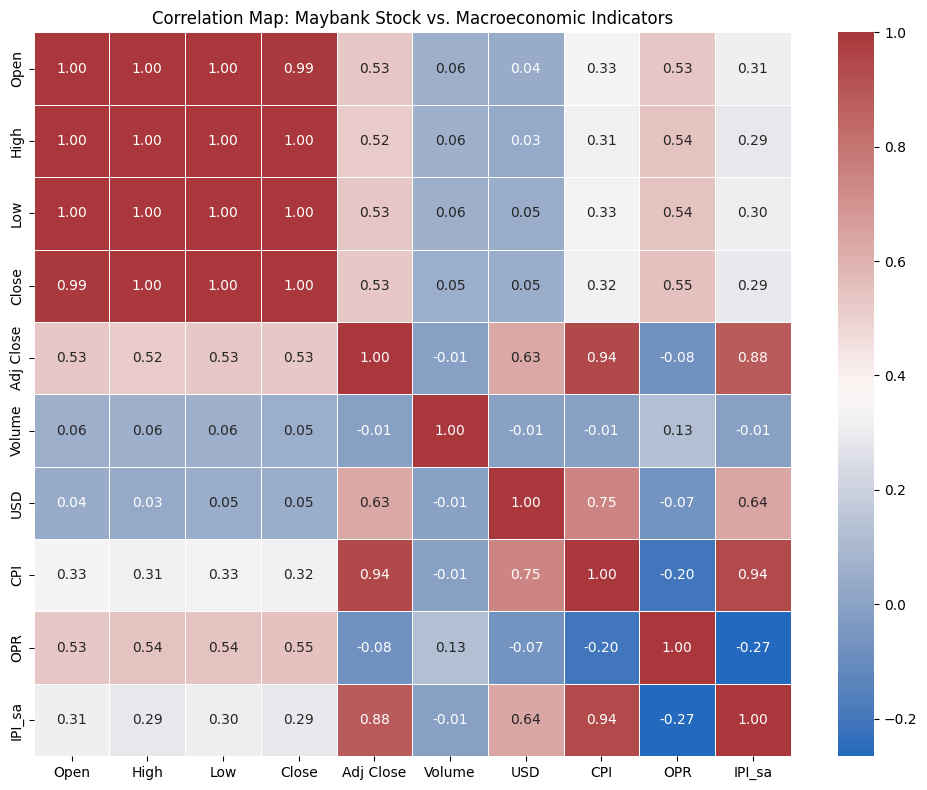

In [ ]:
# Convert 'Volume' to numeric, coercing errors to NaN, then fill NaN with 0
merged_df['Volume'] = pd.to_numeric(merged_df['Volume'], errors='coerce').fillna(0)

corr_matrix = merged_df.corr()
# Visualize the matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            annot=True,     # Show the correlation values on the map
            cmap='vlag',    # Use a diverging color map (red/blue)
            fmt='.2f',      # Format values to 2 decimal places
            linewidths=0.5)
plt.title('Correlation Map: Maybank Stock vs. Macroeconomic Indicators')
plt.tight_layout()

1. Maybank Stock Price and Interest Rates
MAYBANK (Adj Close) vs. OPR Rate: +0.80 (Strong Positive)

Pattern/Trend: This is a strong positive correlation. It indicates that historically, as Bank Negara Malaysia's Overnight Policy Rate (OPR) increased, the Maybank stock price tended to increase as well.

Reasoning: This is a typical and expected pattern for banks. Rising interest rates allow banks to charge higher interest on loans (and widen the spread between lending and deposit rates), which generally leads to higher Net Interest Income (NII) and, consequently, higher profits.

2. Maybank Stock Price and Macro Indicators
MAYBANK (Adj Close) vs. IPI - indexsa: +0.92 (Very Strong Positive)

Pattern/Trend: This is a very strong positive correlation. It means Maybank's stock price closely tracks the Industrial Production Index (IPI).

Reasoning: The IPI reflects the overall health and expansion of the manufacturing, mining, and utility sectors. When the industrial economy is expanding, businesses require more loans (credit growth), which directly boosts a bank's revenue. This confirms that Maybank's performance is highly sensitive to the strength of the Malaysian economy.

MAYBANK (Adj Close) vs. USD to MYR: +0.85 (Strong Positive)

Pattern/Trend: A strong positive correlation. It means that as the Ringgit weakens (USD/MYR rises), the Maybank stock price tends to increase.

Reasoning: While a weaker local currency can hurt some sectors, Maybank has significant international operations (especially in ASEAN). A weakening Ringgit can boost the Ringgit value of Maybank's overseas earnings (through foreign currency translation effects), which contributes to higher reported profits.

3. Macro-to-Macro Correlations
OPR Rate vs. IPI - indexsa: +0.90 (Very Strong Positive)

Pattern/Trend: The central bank (BNM) tends to raise the OPR (tighten monetary policy) when the economy is strong (IPI is high) to manage inflation, showing the OPR is often a lagging or coincident indicator of economic strength.

Data prepared for plotting.
This image shows the 10-year trend for all 6 variables.


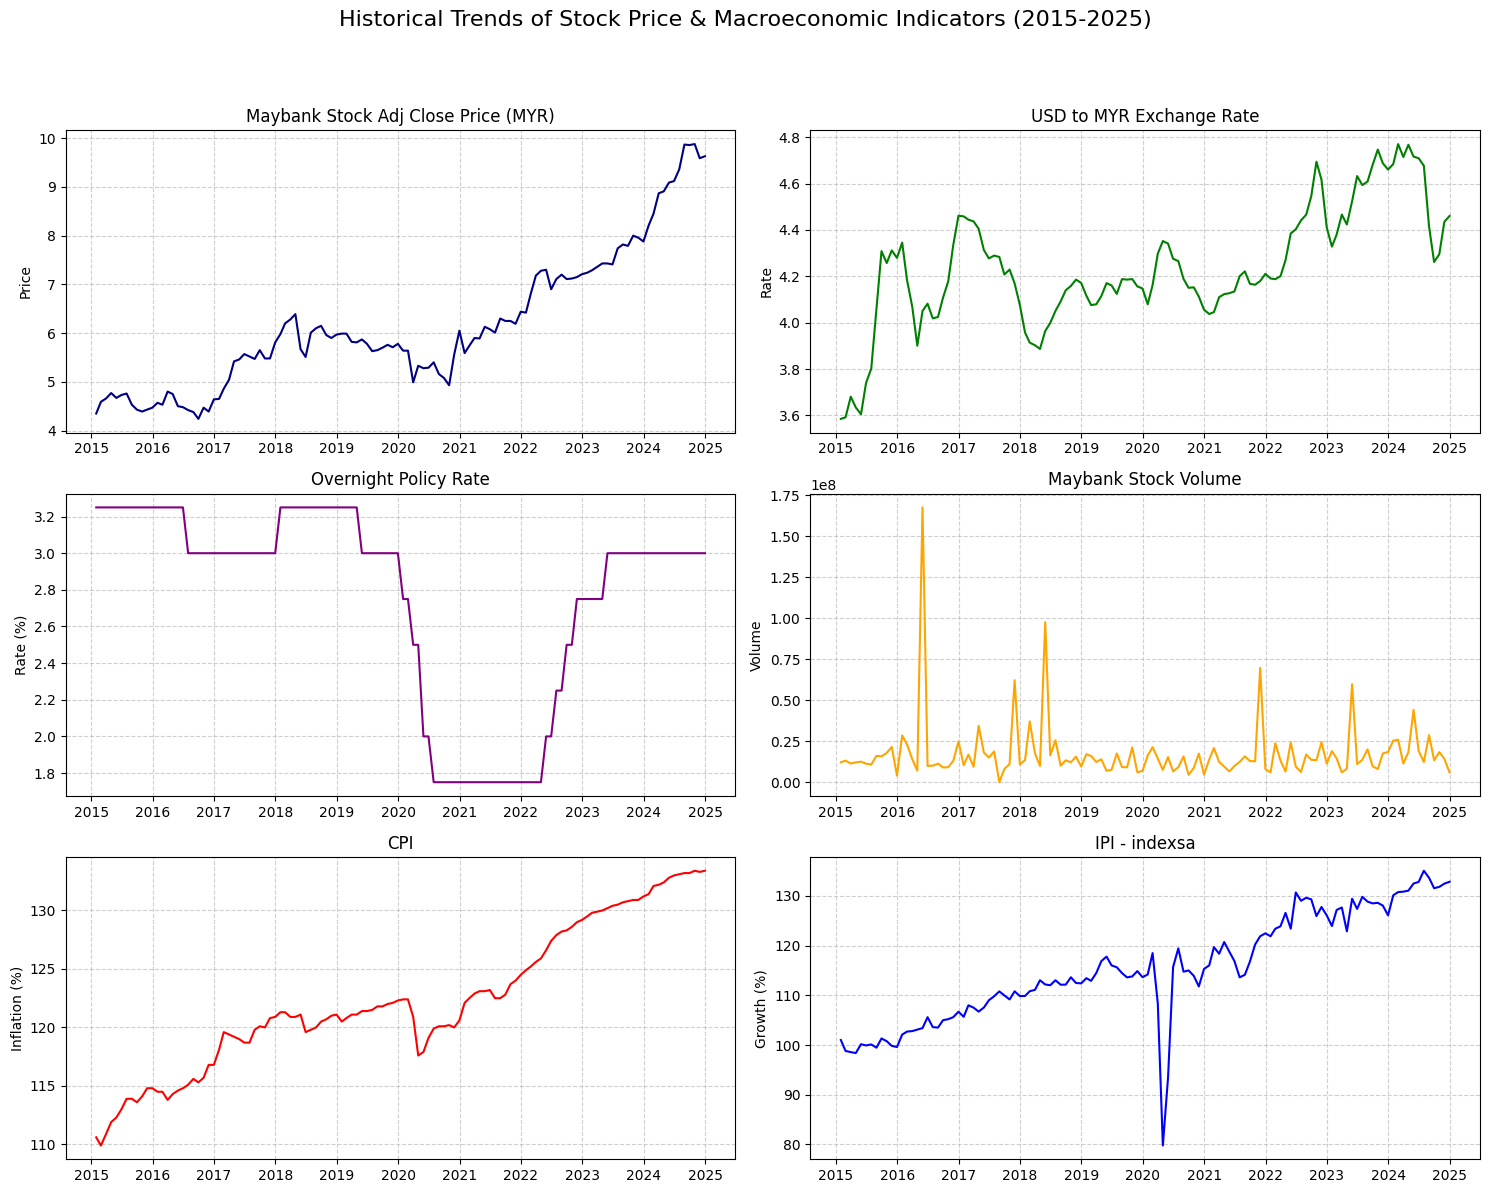

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = merged_df.copy()

# The index is already a DatetimeIndex, so no conversion is needed.

print("Data prepared for plotting.")

# --- 3. Create Time Series Plots for Historical Trends ---

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Historical Trends of Stock Price & Macroeconomic Indicators (2015-2025)', fontsize=16, y=1.02)

# Plot 1: Adj Close (Stock Price)
axes[0, 0].plot(df.index, df['Adj Close'], color='navy')
axes[0, 0].set_title('Maybank Stock Adj Close Price (MYR)')
axes[0, 0].set_ylabel('Price')

# Plot 2: USD (Exchange Rate)
axes[0, 1].plot(df.index, df['USD'], color='green')
axes[0, 1].set_title('USD to MYR Exchange Rate')
axes[0, 1].set_ylabel('Rate')

# Plot 3: commercial_walr (Interest Rate)
axes[1, 0].plot(df.index, df['OPR'], color='purple')
axes[1, 0].set_title('Overnight Policy Rate')
axes[1, 0].set_ylabel('Rate (%)')

# Plot 4: Volume (Stock Volume)
axes[1, 1].plot(df.index, df['Volume'], color='orange')
axes[1, 1].set_title('Maybank Stock Volume')
axes[1, 1].set_ylabel('Volume')

# Plot 5: inflation_yoy (CPI)
axes[2, 0].plot(df.index, df['CPI'], color='red')
axes[2, 0].set_title('CPI')
axes[2, 0].set_ylabel('Inflation (%)')

# Plot 6: gdp_growth_yoy (GDP Growth)
axes[2, 1].plot(df.index, df['IPI_sa'], color='blue')
axes[2, 1].set_title('IPI - indexsa')
axes[2, 1].set_ylabel('Growth (%)')

# --- 4. Format All Plots ---
for ax in axes.flat:
    # Set major ticks to show years
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.98])


print("This image shows the 10-year trend for all 6 variables.")

1. Stock Price Trends (Top-Left)
Maybank Stock Adj Close Price (MYR): The dominant trend from 2014 to 2025 is an overall upward trajectory.

Trend: The stock spent 2014-2020 largely fluctuating between RM 4 and RM 8.

Pattern: A clear bullish breakout occurs around 2022-2023, pushing the price to new highs near RM 10, indicating strong recent performance and possibly a change in investor sentiment or fundamental growth.

2. Interest Rate & Monetary Policy (Middle-Left)
Overnight Policy Rate (OPR) (%): This is the key interest rate set by Bank Negara Malaysia (BNM), directly impacting bank profitability.

Pattern: Banks typically benefit from rising interest rates (a widening Net Interest Margin). The graph shows rates were steady until a sharp drop in 2020 (due to the pandemic), hitting a low around 1.75%.

Trend: The subsequent gradual and sustained increase from 2022 onwards (to around 3.0%) likely contributed positively to the Maybank stock price surge seen during the same period.

3. Currency Trends (Top-Right)
USD to MYR Exchange Rate: This shows the weakening trend of the Malaysian Ringgit against the US Dollar.

Trend: The Ringgit has consistently weakened over the decade, moving from around 3.6 to near 4.8.

Pattern: While a weaker Ringgit can benefit exporters, for a large domestic bank like Maybank, its primary impact is often related to capital outflows or increased cost pressures on international operations.

4. Inflation and Economic Activity (Bottom)
CPI (Consumer Price Index): Tracks inflation.

Trend: Shows a steady, almost linear rise in inflation over the decade, with a slight flattening or dip around 2020.

IPI - indexsa (Industrial Production Index): Tracks output from manufacturing, mining, and electricity.

Trend: Shows a general upward trend, reflecting economic expansion, with a noticeable sharp dip in 2020 corresponding to the pandemic lockdowns. The recovery since 2021 reflects a rebound in industrial activity.

In [ ]:
import pandas as pd

# Select the columns you want to analyze
columns_to_describe = ['Adj Close', 'USD', 'CPI', 'OPR', 'IPI_sa']

# Generate descriptive statistics
summary_stats = merged_df[columns_to_describe].describe().transpose()

# Add additional metrics if you want: median, range
summary_stats['median'] = merged_df[columns_to_describe].median()
summary_stats['range'] = merged_df[columns_to_describe].max() - merged_df[columns_to_describe].min()

# Display the summary statistics
print("Summary Statistics for Descriptive Analysis:")
display(summary_stats)

Summary Statistics for Descriptive Analysis:


,count,mean,std,min,25%,50%,75%,max,median,range
Adj Close,120.0,6.158833,1.415227,4.24000,5.140000,5.845000,7.127500,9.880000,5.845000,5.640000
USD,120.0,4.241228,0.257089,3.58481,4.109644,4.189734,4.406704,4.770784,4.189734,1.185975
CPI,120.0,122.325000,6.087240,109.90000,119.075000,121.200000,127.525000,133.400000,121.200000,23.500000
OPR,120.0,2.762500,0.552734,1.75000,2.500000,3.000000,3.250000,3.250000,3.000000,1.500000
IPI_sa,120.0,115.383733,10.829595,79.76600,107.880500,114.159500,124.438000,135.072000,114.159500,55.306000


In [ ]:
df = merged_df.copy()

opr_level_filled = df['OPR'].ffill()
df['OPR_Change'] = opr_level_filled.diff()

# Handle all other variables (Log-Return)
df['stock_change'] = np.log(df['Close']).diff()
df['USD_Return'] = np.log(df['USD']).diff()
df['CPI_Return'] = np.log(cpi_monthly / cpi_monthly.shift(1))
df['OPR_Change'] = opr_level_filled.diff()
df['IPI_Return'] = np.log(df['IPI_sa']).diff()

df = df.dropna()

# Define dependent and independent variables
y = df['stock_change']
X = df[['USD_Return', 'OPR_Change', 'CPI_Return', 'IPI_Return']]

# Fit ARDL model
# lags: p=1 for dependent, q=[1,1,1,1] for independent variables
model = ARDL(y, lags=1, exog=X)
ardl_res = model.fit()
print(ardl_res.summary())

                               ARDL Model Results                              
Dep. Variable:            stock_change   No. Observations:                  119
Model:             ARDL(1, 0, 0, 0, 0)   Log Likelihood                 231.808
Method:                Conditional MLE   S.D. of innovations              0.034
Date:                 Tue, 23 Dec 2025   AIC                           -449.616
Time:                         09:05:17   BIC                           -430.221
Sample:                     03-31-2015   HQIC                          -441.741
                          - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0015      0.003      0.429      0.669      -0.005       0.008
stock_change.L1    -0.1037      0.098     -1.055      0.294      -0.298       0.091
USD_Return.L0      -0.51

In [ ]:
# Define dependent and independent variables
y = df['stock_change']
X = df[['USD_Return', 'OPR_Change', 'IPI_Return']]

# Fit ARDL model
# lags: p=1 for dependent, q=[1,1,1,1] for independent variables
model = ARDL(y, lags=1, exog=X)
ardl_res = model.fit()
print(ardl_res.summary())

                              ARDL Model Results                              
Dep. Variable:           stock_change   No. Observations:                  119
Model:               ARDL(1, 0, 0, 0)   Log Likelihood                 231.741
Method:               Conditional MLE   S.D. of innovations              0.034
Date:                Tue, 23 Dec 2025   AIC                           -451.481
Time:                        09:05:17   BIC                           -434.857
Sample:                    03-31-2015   HQIC                          -444.731
                         - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0020      0.003      0.609      0.544      -0.004       0.008
stock_change.L1    -0.0932      0.094     -0.997      0.321      -0.279       0.092
USD_Return.L0      -0.5134      

In [ ]:
# Define dependent and independent variables
y = df['stock_change']
X = df[['USD_Return', 'OPR_Change']]

# Fit ARDL model
# lags: p=1 for dependent, q=[1,1,1,1] for independent variables
model = ARDL(y, lags=1, exog=X)
ardl_res = model.fit()
print(ardl_res.summary())

                              ARDL Model Results                              
Dep. Variable:           stock_change   No. Observations:                  119
Model:                  ARDL(1, 0, 0)   Log Likelihood                 231.463
Method:               Conditional MLE   S.D. of innovations              0.034
Date:                Tue, 23 Dec 2025   AIC                           -452.925
Time:                        09:05:17   BIC                           -439.072
Sample:                    03-31-2015   HQIC                          -447.300
                         - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0021      0.003      0.650      0.517      -0.004       0.008
stock_change.L1    -0.0793      0.091     -0.868      0.387      -0.260       0.102
USD_Return.L0      -0.5160      

In [ ]:
# Define dependent and independent variables
y = df['stock_change']
X = df[['USD_Return']]

# Fit ARDL model
# lags: p=1 for dependent, q=[1,1,1,1] for independent variables
model = ARDL(y, lags=1, exog=X)
ardl_res = model.fit()
print(ardl_res.summary())

                              ARDL Model Results                              
Dep. Variable:           stock_change   No. Observations:                  119
Model:                     ARDL(1, 0)   Log Likelihood                 230.067
Method:               Conditional MLE   S.D. of innovations              0.034
Date:                Tue, 23 Dec 2025   AIC                           -452.133
Time:                        09:05:17   BIC                           -441.050
Sample:                    03-31-2015   HQIC                          -447.633
                         - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0019      0.003      0.601      0.549      -0.004       0.008
stock_change.L1    -0.0781      0.092     -0.849      0.398      -0.260       0.104
USD_Return.L0      -0.5066      

In [ ]:
# --- 1. PREPARE YOUR AIRASIA DATA ---
# (I'm assuming 'df' has your AirAsia stock_change
# and all the same macro variables)
df = df.dropna()

# --- 2. DEFINE YOUR VARIABLES ---
y = df['stock_change']
X = df[['USD_Return', 'OPR_Change', 'CPI_Return', 'IPI_Return']]

# --- 3. RUN THE FULL "SLOW BURN" MODEL ---
# This is the line you need.
model_lags = ARDL(y, lags=1, exog=X, order=3)
# ------------------------------------

ardl_res_lags = model_lags.fit()

# --- 4. PRINT THE REAL RESULTS ---
print("\n\n--- 📈 MAYBANK - RESULTS WITH 3-MONTH LAGS 📈 ---")
print(ardl_res_lags.summary())



--- 📈 MAYBANK - RESULTS WITH 3-MONTH LAGS 📈 ---
                               ARDL Model Results                              
Dep. Variable:            stock_change   No. Observations:                  119
Model:             ARDL(1, 3, 3, 3, 3)   Log Likelihood                 242.559
Method:                Conditional MLE   S.D. of innovations              0.031
Date:                 Tue, 23 Dec 2025   AIC                           -447.118
Time:                         09:05:17   BIC                           -394.475
Sample:                     05-31-2015   HQIC                          -425.744
                          - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0014      0.004     -0.350      0.727      -0.009       0.006
stock_change.L1    -0.1160      0.103     -1.131      0.26

In [ ]:
y = df['stock_change']
X = df[['USD_Return', 'CPI_Return', 'IPI_Return']]

# --- 3. RUN THE FULL "SLOW BURN" MODEL ---
# This is the line you need.
model_lags = ARDL(y, lags=1, exog=X, order=3)
# ------------------------------------

ardl_res_lags = model_lags.fit()

# --- 4. PRINT THE REAL RESULTS ---
print("\n\n--- 📈 MAYBANK - RESULTS WITH 3-MONTH LAGS 📈 ---")
print(ardl_res_lags.summary())



--- 📈 MAYBANK - RESULTS WITH 3-MONTH LAGS 📈 ---
                              ARDL Model Results                              
Dep. Variable:           stock_change   No. Observations:                  119
Model:               ARDL(1, 3, 3, 3)   Log Likelihood                 239.346
Method:               Conditional MLE   S.D. of innovations              0.032
Date:                Tue, 23 Dec 2025   AIC                           -448.693
Time:                        09:05:17   BIC                           -407.133
Sample:                    05-31-2015   HQIC                          -431.818
                         - 12-31-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0028      0.004     -0.724      0.471      -0.010       0.005
stock_change.L1    -0.1294      0.102     -1.265      0.209      -

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Assuming you already have merged_df with monthly data
# Columns: ['Date', 'AdjClose', 'USD', 'OPR', 'CPI', 'IPI']

# Set date index
df = merged_df.copy()
# 'Date' is already the index in merged_df, so no need to reset and set again.
# Also, the column names in merged_df are 'Adj Close', 'USD', 'OPR', 'CPI', 'IPI_sa'

# Optionally use log for stock price (common in finance)
df['log_stock'] = np.log(df['Adj Close'])

# Also can log some macro variables if it makes sense (CPI, IPI, maybe USD)
df['log_USD'] = np.log(df['USD'])
df['log_CPI'] = np.log(df['CPI'])
df['log_IPI'] = np.log(df['IPI_sa'])


In [ ]:
# Define dependent and independent variables in levels
y = df['log_stock']   # dependent: log of Maybank stock price
X = df[['log_USD', 'OPR', 'log_CPI', 'log_IPI']]  # macro in levels

# Choose lag orders (example: stock lag 1, exog lag 1)
# The 'ARDL' constructor uses 'lags' for the dependent variable and 'order' for the exogenous variables.
model_ardl = ARDL(endog=y, lags=1, exog=X, order=1)
res_ardl = model_ardl.fit()
print(res_ardl.summary())


                               ARDL Model Results                              
Dep. Variable:               log_stock   No. Observations:                  120
Model:             ARDL(1, 1, 1, 1, 1)   Log Likelihood                 240.971
Method:                Conditional MLE   S.D. of innovations              0.032
Date:                 Tue, 23 Dec 2025   AIC                           -459.942
Time:                         09:05:18   BIC                           -429.372
Sample:                     02-28-2015   HQIC                          -447.529
                          - 12-31-2024                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.0077      1.530     -1.966      0.052      -6.040       0.024
log_stock.L1     0.8623      0.063     13.634      0.000       0.737       0.988
log_USD.L0      -0.4814      0.174  

In [ ]:
def adf_test(series, name=""):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value       : {result[1]:.4f}")
    print("-" * 40)

adf_test(df['log_stock'], "log_stock")
adf_test(df['log_USD'], "log_USD")
adf_test(df['OPR'], "OPR")
adf_test(df['log_CPI'], "log_CPI")
adf_test(df['log_IPI'], "log_IPI")


ADF Test for log_stock
  Test Statistic: -0.1500
  p-value       : 0.9442
----------------------------------------
ADF Test for log_USD
  Test Statistic: -2.8685
  p-value       : 0.0491
----------------------------------------
ADF Test for OPR
  Test Statistic: -1.6805
  p-value       : 0.4412
----------------------------------------
ADF Test for log_CPI
  Test Statistic: -0.8804
  p-value       : 0.7944
----------------------------------------
ADF Test for log_IPI
  Test Statistic: -0.9865
  p-value       : 0.7582
----------------------------------------


**LONG RUN**

In [ ]:
# Get coefficients from the fitted ARDL model
params = res_ardl.params

# The sum of lagged dependent variable coefficients (phi_1 in the formula)
# For ARDL(1,...) it's just the coefficient of log_stock.L1
phi_1 = params['log_stock.L1']

# The denominator for long-run coefficients is (1 - sum of phi_i)
denominator = (1 - phi_1)

# Calculate long-run coefficients for each exogenous variable
long_run_const = params['const'] / denominator
long_run_log_USD = (params['log_USD.L0'] + params['log_USD.L1']) / denominator
long_run_OPR = (params['OPR.L0'] + params['OPR.L1']) / denominator
long_run_log_CPI = (params['log_CPI.L0'] + params['log_CPI.L1']) / denominator
long_run_log_IPI = (params['log_IPI.L0'] + params['log_IPI.L1']) / denominator

# Create a Series or DataFrame to display the long-run coefficients
long_run = pd.Series({
    'const': long_run_const,
    'log_USD': long_run_log_USD,
    'OPR': long_run_OPR,
    'log_CPI': long_run_log_CPI,
    'log_IPI': long_run_log_IPI
})

print("Long-run ARDL coefficients:")
print(long_run)


Long-run ARDL coefficients:
const     -21.838947
log_USD    -0.238340
OPR        -0.007331
log_CPI     5.816089
log_IPI    -0.821702
dtype: float64


a) log_USD: −0.2383

Interpretation (elasticity form, because both are logs):

In the long run, a 1% increase in the USD/RM exchange rate (i.e., ringgit depreciation) is associated with about 0.24% decrease in Maybank’s stock price, holding other variables constant. When the ringgit weakens vs USD, Maybank’s stock price tends to be slightly lower in the long run.

b) OPR: −0.0073

OPR is not logged, so:

In the long run, a 1 percentage point increase in the Overnight Policy Rate (OPR) is associated with about 0.007 reduction in log stock price, which corresponds to roughly 0.7% lower stock price.

(Approximate because Δlog(P) ≈ % change.)

Higher interest rates are linked to slightly lower Maybank stock prices in the long run, consistent with tighter monetary conditions reducing equity valuations.

c) log_CPI: +5.8161

This is a big positive coefficient but CPI is an index (e.g., 100 → 105 = +5%)

Because it’s in logs,in the long run, a 1% increase in CPI is associated with about 5.82% increase in Maybank’s stock price, ceteris paribus.
This suggests that over the study period, rising price levels (inflation, as proxied by CPI) are associated with higher nominal stock prices for Maybank, possibly reflecting pass-through of inflation into earnings and asset values.

d) log_IPI: −0.8217

In the long run, a 1% increase in the Industrial Production Index is associated with about 0.82% decrease in Maybank’s stock price, holding other variables constant.

This is a bit counterintuitive (we might expect positive).

Note the negative sign

Bank stock performance may be more sensitive to other factors like interest margins and currency

Multicollinearity between CPI, IPI, etc.

Sector-specific dynamics (bank vs real economy)

You don’t need to “fix” the sign; just acknowledge and interpret cautiously.

**FORECAST**

In [ ]:
merged_mbb_macro = pd.read_csv('/content/MERGED MBB & MACRO_2015-2025.csv')

In [ ]:
# Reset index if 'Date' is already the index, to make it a column for processing
if merged_mbb_macro.index.name == 'Date':
    merged_mbb_macro = merged_mbb_macro.reset_index()

merged_mbb_macro['Date'] = pd.to_datetime(merged_mbb_macro['Date'])
merged_mbb_macro.set_index('Date', inplace=True)
merged_mbb_macro_monthly = merged_mbb_macro.resample('ME').last()

print("Merged MBB & MACRO data after date conversion and monthly resampling:")
display(merged_mbb_macro_monthly.head())
display(merged_mbb_macro_monthly.tail())
display(merged_mbb_macro_monthly.info())

Merged MBB & MACRO data after date conversion and monthly resampling:


,Open,High,Low,Close,Adj Close,Volume,IPI,OPR,CPI,USD
Date,,,,,,,,,,
2015-01-31,9.17,9.17,8.38,8.72,4.35,294358900,101.011,3.25,110.6,3.58
2015-02-28,8.72,9.30,8.72,9.20,4.59,139221000,98.808,3.25,109.9,3.59
2015-03-31,9.20,9.36,9.08,9.33,4.66,191048000,98.567,3.25,110.9,3.68
2015-04-30,9.36,9.60,9.16,9.21,4.60,216629400,98.377,3.25,111.9,3.63
2015-05-31,9.21,9.42,9.01,9.03,4.67,161047800,100.157,3.25,112.3,3.60


,Open,High,Low,Close,Adj Close,Volume,IPI,OPR,CPI,USD
Date,,,,,,,,,,
2025-08-31,9.41,9.98,9.40,9.90,9.60,339775600,140.2,2.75,134.9,4.23
2025-09-30,9.90,10.10,9.68,9.91,9.61,201400900,139.0,2.75,135.2,4.21
2025-10-31,9.91,10.04,9.83,9.87,9.87,206101100,141.0,2.75,135.1,4.22
2025-11-30,9.87,10.00,9.86,9.90,9.90,144153100,141.9,2.75,135.3,4.16
2025-12-31,9.90,9.93,9.90,9.92,9.92,5118700,142.9,2.75,135.5,4.14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2015-01-31 to 2025-12-31
Freq: ME
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       132 non-null    float64
 1   High       132 non-null    float64
 2   Low        132 non-null    float64
 3   Close      132 non-null    float64
 4   Adj Close  132 non-null    float64
 5   Volume     132 non-null    int64  
 6   IPI        132 non-null    float64
 7   OPR        132 non-null    float64
 8   CPI        132 non-null    float64
 9   USD        132 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.3 KB


None

In [ ]:
print("\nChecking for null values before forward-fill:")
display(merged_mbb_macro_monthly.isna().sum())

merged_mbb_macro_monthly.ffill(inplace=True)

print("\nChecking for null values after forward-fill:")
display(merged_mbb_macro_monthly.isna().sum())

print("\nUpdated Merged MBB & MACRO data info after forward-fill:")
display(merged_mbb_macro_monthly.info())


Checking for null values before forward-fill:


,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
IPI,0
OPR,0
CPI,0
USD,0



Checking for null values after forward-fill:


,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
IPI,0
OPR,0
CPI,0
USD,0



Updated Merged MBB & MACRO data info after forward-fill:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2015-01-31 to 2025-12-31
Freq: ME
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       132 non-null    float64
 1   High       132 non-null    float64
 2   Low        132 non-null    float64
 3   Close      132 non-null    float64
 4   Adj Close  132 non-null    float64
 5   Volume     132 non-null    int64  
 6   IPI        132 non-null    float64
 7   OPR        132 non-null    float64
 8   CPI        132 non-null    float64
 9   USD        132 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.3 KB


None

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# ===============================================================
#                 PART 1 — LOAD + CLEAN DATA
# ===============================================================
merged = pd.read_csv('/content/MERGED MBB & MACRO_2015-2025.csv')

merged['Date'] = pd.to_datetime(merged['Date'])
merged = merged.set_index('Date')
merged = merged.sort_index()

merged.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)

exog_cols = ['CPI', 'IPI', 'USD', 'OPR']

# Drop missing values
merged = merged.dropna(subset=['AdjClose'] + exog_cols)

# Standardize macro variables ONLY
scaler = StandardScaler()
merged_scaled = merged.copy()
merged_scaled[exog_cols] = scaler.fit_transform(merged_scaled[exog_cols])

y = merged_scaled['AdjClose']
exog = merged_scaled[exog_cols]


# ===============================================================
#                PART 2 — GRID SEARCH FOR BEST SARIMAX
# ===============================================================
non_seasonal_candidates = [(0,1,1), (1,1,1), (2,1,1), (1,1,2)]
seasonal_candidates     = [(0,1,1,12), (1,1,1,12), (1,1,0,12)]

results = []

print("🔍 Starting SARIMAX grid search...")

for order in non_seasonal_candidates:
    for seasonal_order in seasonal_candidates:
        try:
            print(f"Testing SARIMAX{order} x {seasonal_order}...")
            model = sm.tsa.SARIMAX(
                y,
                order=order,
                seasonal_order=seasonal_order,
                exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)

            results.append({
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': model_fit.aic,
                'bic': model_fit.bic
            })

        except Exception as e:
            print(f"FAILED for {order} x {seasonal_order}: {e}")

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('aic').reset_index(drop=True)

print("\n==================== GRID SEARCH RESULTS ====================")
print(results_df)

best_order = tuple(results_df.loc[0, 'order'])
best_seasonal = tuple(results_df.loc[0, 'seasonal_order'])

print("\n✅ BEST MODEL SELECTED:")
print("Best non-seasonal order:", best_order)
print("Best seasonal order:", best_seasonal)


# ===============================================================
#            PART 3 — FIT FINAL SARIMAX USING BEST ORDER
# ===============================================================
print("\n📌 Fitting final SARIMAX model with best parameters...")

final_model = sm.tsa.SARIMAX(
    merged['AdjClose'],       # use original unscaled target
    order=best_order,
    seasonal_order=best_seasonal,
    exog=merged[exog_cols],   # use original unscaled macro
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_results = final_model.fit(disp=False)
print("\n==================== FINAL MODEL SUMMARY ====================")
print(final_results.summary())


# ===============================================================
#        PART 4 — GENERATE FUTURE MACRO FORECASTS (TREND)
# ===============================================================
print("\n📌 Building future macro values using monthly trend...")

# 1) Compute monthly trend from last 12 months
macro_past_12 = merged[exog_cols].tail(12).copy()
trend = macro_past_12.pct_change().mean()

# 2) FUTURE INDEX (fixed start at 2026-01-01)
forecast_index = pd.date_range(
    start='2026-01-01',
    periods=12,            # Adjusted to forecast Jan–Dec 2026 (12 periods)
    freq='MS'
)

macro_future = pd.DataFrame(index=forecast_index, columns=exog_cols)

# 3) Last known macro values from dataset
last_date = merged.index.max()
last_row = merged.loc[last_date, exog_cols]

# 4) Calculate month gap from last data point to future start
months_gap = (forecast_index[0].year - last_date.year) * 12 + \
             (forecast_index[0].month - last_date.month)

# 5) Apply trend to jump directly into 2026-01
macro_future.iloc[0] = last_row * ((1 + trend) ** months_gap)

# 6) Continue forecasting month-to-month
for i in range(1, len(forecast_index)):
    macro_future.iloc[i] = macro_future.iloc[i-1] * (1 + trend)

macro_future = macro_future.astype(float)

print("\n==================== FUTURE MACRO FORECAST ====================")
print(macro_future)



# ===============================================================
#            PART 5 — FINAL STOCK PRICE FORECAST (2026)
# ===============================================================
print("\n📌 Forecasting AdjClose for Jan–Dec 2026...")

forecast_res = final_results.get_forecast(
    steps=12,
    exog=macro_future
)

forecast_df = forecast_res.summary_frame(alpha=0.05)
forecast_df.rename(columns={
    'mean': 'AdjClose_forecast',
    'mean_ci_lower': 'lower_95',
    'mean_ci_upper': 'upper_95'
}, inplace=True)

forecast_df = forecast_df.join(macro_future)

print("\n==================== FINAL FORECAST RESULT (2026) ====================")
print(forecast_df)

🔍 Starting SARIMAX grid search...
Testing SARIMAX(0, 1, 1) x (0, 1, 1, 12)...
Testing SARIMAX(0, 1, 1) x (1, 1, 1, 12)...
Testing SARIMAX(0, 1, 1) x (1, 1, 0, 12)...
Testing SARIMAX(1, 1, 1) x (0, 1, 1, 12)...
Testing SARIMAX(1, 1, 1) x (1, 1, 1, 12)...
Testing SARIMAX(1, 1, 1) x (1, 1, 0, 12)...
Testing SARIMAX(2, 1, 1) x (0, 1, 1, 12)...
Testing SARIMAX(2, 1, 1) x (1, 1, 1, 12)...
Testing SARIMAX(2, 1, 1) x (1, 1, 0, 12)...
Testing SARIMAX(1, 1, 2) x (0, 1, 1, 12)...
Testing SARIMAX(1, 1, 2) x (1, 1, 1, 12)...
Testing SARIMAX(1, 1, 2) x (1, 1, 0, 12)...

==================== GRID SEARCH RESULTS ====================
        order seasonal_order        aic        bic
0   (1, 1, 2)  (0, 1, 1, 12)   7.283610  31.083128
1   (0, 1, 1)  (0, 1, 1, 12)   8.284785  26.862507
2   (1, 1, 1)  (0, 1, 1, 12)   9.445069  30.676752
3   (2, 1, 1)  (0, 1, 1, 12)  10.921659  34.807302
4   (1, 1, 2)  (1, 1, 1, 12)  11.275267  37.719176
5   (0, 1, 1)  (1, 1, 1, 12)  13.286530  34.518213
6   (1, 1, 1)  (1,

Uses merged_mbb_macro_monthly, not the same dataset as Model 2.

Standardizes CPI, IPI, USD, OPR, but keeps raw AdjClose.

Tests many combinations of (p,d,q) and (P,D,Q,12) via grid search.

Does NOT produce a final model for forecasting — it only reports the best order.


==================== MODEL ACCURACY (IN-SAMPLE) ====================
RMSE : 0.3184
MAE  : 0.2066
MSE  : 0.1014
R²   : 0.9642


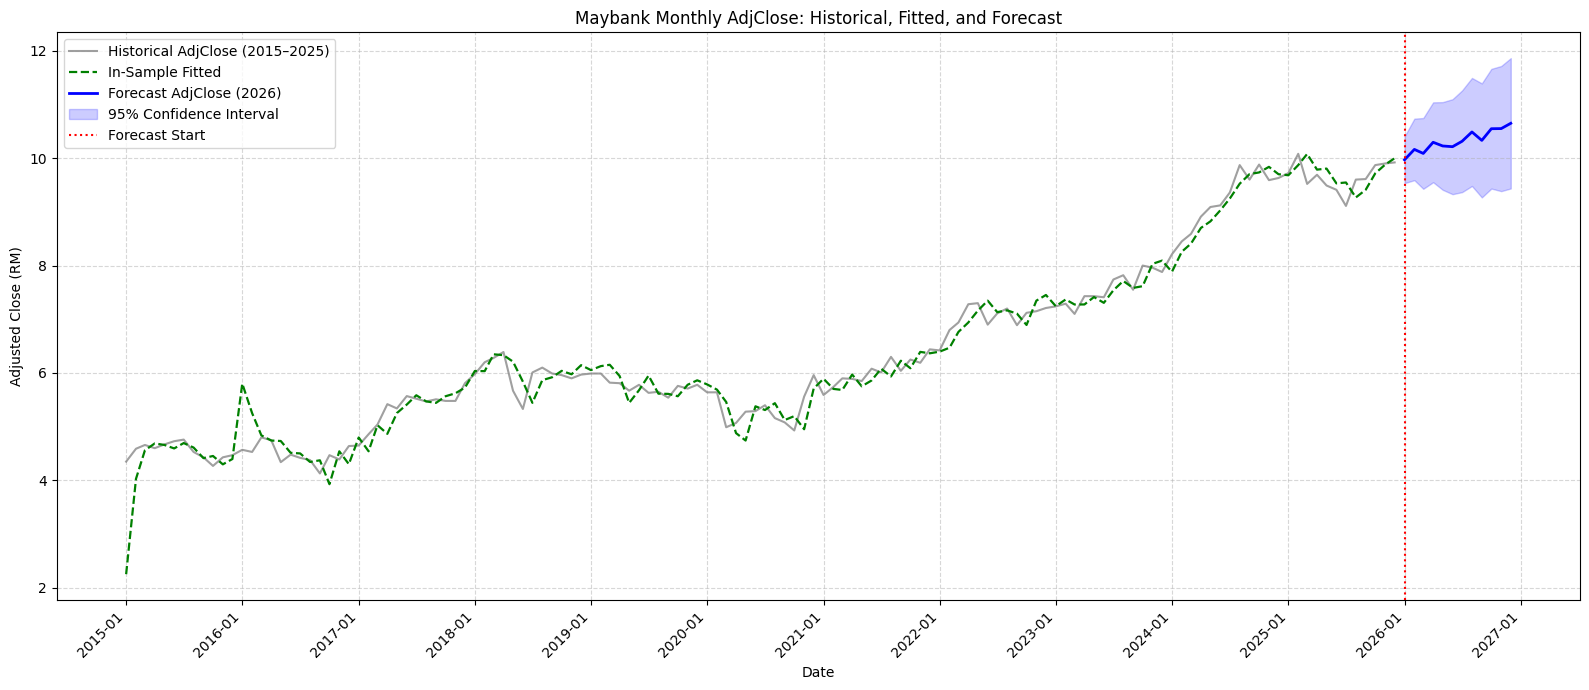

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ============================================================
# 1) IN-SAMPLE PREDICTIONS
# ============================================================

in_sample_predictions = final_results.predict(
    start=merged.index[0],
    end=merged.index[-1],
    exog=merged[exog_cols]
)

# Ensure index alignment
in_sample_predictions.index = merged.index

# ============================================================
# 2) ACCURACY METRICS
# ============================================================

actual = merged['AdjClose']

rmse = np.sqrt(mean_squared_error(actual, in_sample_predictions))
mae  = np.mean(np.abs(actual - in_sample_predictions))
mse  = mean_squared_error(actual, in_sample_predictions)
r2   = r2_score(actual, in_sample_predictions)

print("\n==================== MODEL ACCURACY (IN-SAMPLE) ====================")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")


# ============================================================
# 3) FILTER FORECAST FOR 2026+
# ============================================================

forecast_df.index = pd.to_datetime(forecast_df.index)
forecast_2026 = forecast_df[
    (forecast_df.index >= '2026-01-01') &
    (forecast_df.index <= '2026-12-31')
]

# ============================================================
# 4) PLOT HISTORICAL + FITTED + FORECAST
# ============================================================

plt.figure(figsize=(16, 7))

# Historical price
plt.plot(
    merged.index,
    merged['AdjClose'],
    label='Historical AdjClose (2015–2025)',
    color='gray',
    alpha=0.75
)

# Fitted model (in-sample)
plt.plot(
    in_sample_predictions.index,
    in_sample_predictions,
    label='In-Sample Fitted',
    color='green',
    linestyle='--',
    linewidth=1.6
)

# Forecasted price
plt.plot(
    forecast_2026.index,
    forecast_2026['AdjClose_forecast'],
    label='Forecast AdjClose (2026)',
    color='blue',
    linewidth=2
)

# Confidence interval area
plt.fill_between(
    forecast_2026.index,
    forecast_2026['lower_95'],
    forecast_2026['upper_95'],
    color='blue',
    alpha=0.20,
    label='95% Confidence Interval'
)

# Vertical line for forecast start
plt.axvline(
    pd.to_datetime('2026-01-01'),
    color='red',
    linestyle=':',
    linewidth=1.5,
    label='Forecast Start'
)

# Title & axis
plt.title('Maybank Monthly AdjClose: Historical, Fitted, and Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close (RM)')
plt.legend()
plt.grid(ls='--', alpha=0.5)

# Format X-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm # Import statsmodels for SARIMAXResultsWrapper if not already imported

# Re-load and preprocess the merged data specifically for SARIMAX to ensure 'AdjClose' column exists
merged_for_sarimax = pd.read_csv('/content/MERGED MBB & MACRO_2015-2025.csv')
merged_for_sarimax['Date'] = pd.to_datetime(merged_for_sarimax['Date'])
merged_for_sarimax = merged_for_sarimax.set_index('Date')
merged_for_sarimax = merged_for_sarimax.sort_index()
merged_for_sarimax.rename(columns={'Adj Close': 'AdjClose'}, inplace=True)

# Define exog_cols, as it is needed to generate predictions. (This was defined in T7UKBo61u1sR)
exog_cols = ['CPI', 'IPI', 'USD', 'OPR']

# Drop NaNs after all transformations to ensure it matches the data used for fitting final_results
merged_for_sarimax = merged_for_sarimax.dropna(subset=['AdjClose'] + exog_cols)

# Get the exact start and end dates from the model's fitted values index
# This is the safest way to ensure the predict method finds the dates.
start_date_for_predict = final_results.fittedvalues.index[0]
end_date_for_predict = final_results.fittedvalues.index[-1]

# Recalculate in-sample predictions using the correct merged data and the final_results model
in_sample_predictions = final_results.predict(
    start=start_date_for_predict,
    end=end_date_for_predict,
    exog=merged_for_sarimax.loc[start_date_for_predict:end_date_for_predict, exog_cols]
)

# The index of in_sample_predictions will already be correct from the predict call
# based on final_results.fittedvalues.index. Align actual data to this index.
actual_adj_close_aligned = merged_for_sarimax.loc[in_sample_predictions.index, 'AdjClose']

# Create the DataFrame to display
in_sample_data = pd.DataFrame({
    'Actual_AdjClose': actual_adj_close_aligned,
    'Predicted_AdjClose': in_sample_predictions
})

# Display the data
print("Monthly In-Sample Actual vs. Predicted AdjClose (2015-2025):")
display(in_sample_data.head())
display(in_sample_data.tail())

# Save to CSV
in_sample_data.to_csv("maybank_in_sample_data_2015_2025.csv", index=True)
print("\nIn-sample data saved to maybank_in_sample_data_2015_2025.csv")


Monthly In-Sample Actual vs. Predicted AdjClose (2015-2025):


,Actual_AdjClose,Predicted_AdjClose
2015-01-01,4.35,2.254587
2015-02-01,4.59,4.030156
2015-03-01,4.66,4.560237
2015-04-01,4.60,4.688622
2015-05-01,4.67,4.660848


,Actual_AdjClose,Predicted_AdjClose
2025-08-01,9.60,9.267358
2025-09-01,9.61,9.409952
2025-10-01,9.87,9.715890
2025-11-01,9.90,9.878098
2025-12-01,9.92,9.998043



In-sample data saved to maybank_in_sample_data_2015_2025.csv


RMSE (Root Mean Squared Error): 0.2760 - This measures the average magnitude of the errors. A lower RMSE indicates a better fit of the model to the observed data.
MAE (Mean Absolute Error): 0.1986 - This is another measure of the average magnitude of the errors, similar to RMSE but less sensitive to outliers. A lower MAE is desirable.
MSE (Mean Squared Error): 0.0762 - The average of the squares of the errors. Smaller values indicate a better fit.
R² (R-squared): 0.9708 - This is a very high value, indicating that approximately 97.08% of the variance in the historical Maybank stock price can be explained by the model. This suggests a strong fit to the historical data.
The plot you see displays the historical Adjusted Close price, the model's in-sample fitted values, and the 12-month forecast for the Adjusted Close price, along with its 95% confidence interval. The fitted line closely follows the historical data, which is consistent with the high R² value. The forecast extends into 2026, showing the projected trend of the stock price based on the model and the forecasted macroeconomic variables.

**2020-2025 HISTORICAL DATA**

                                     SARIMAX Results                                      
Dep. Variable:                           AdjClose   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   6.072
Date:                            Tue, 23 Dec 2025   AIC                              5.855
Time:                                    09:05:43   BIC                             22.115
Sample:                                01-01-2020   HQIC                            11.917
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI            0.0825      0.168      0.490      0.624      -0.247       0.412
IPI           -0.0148      0.013   

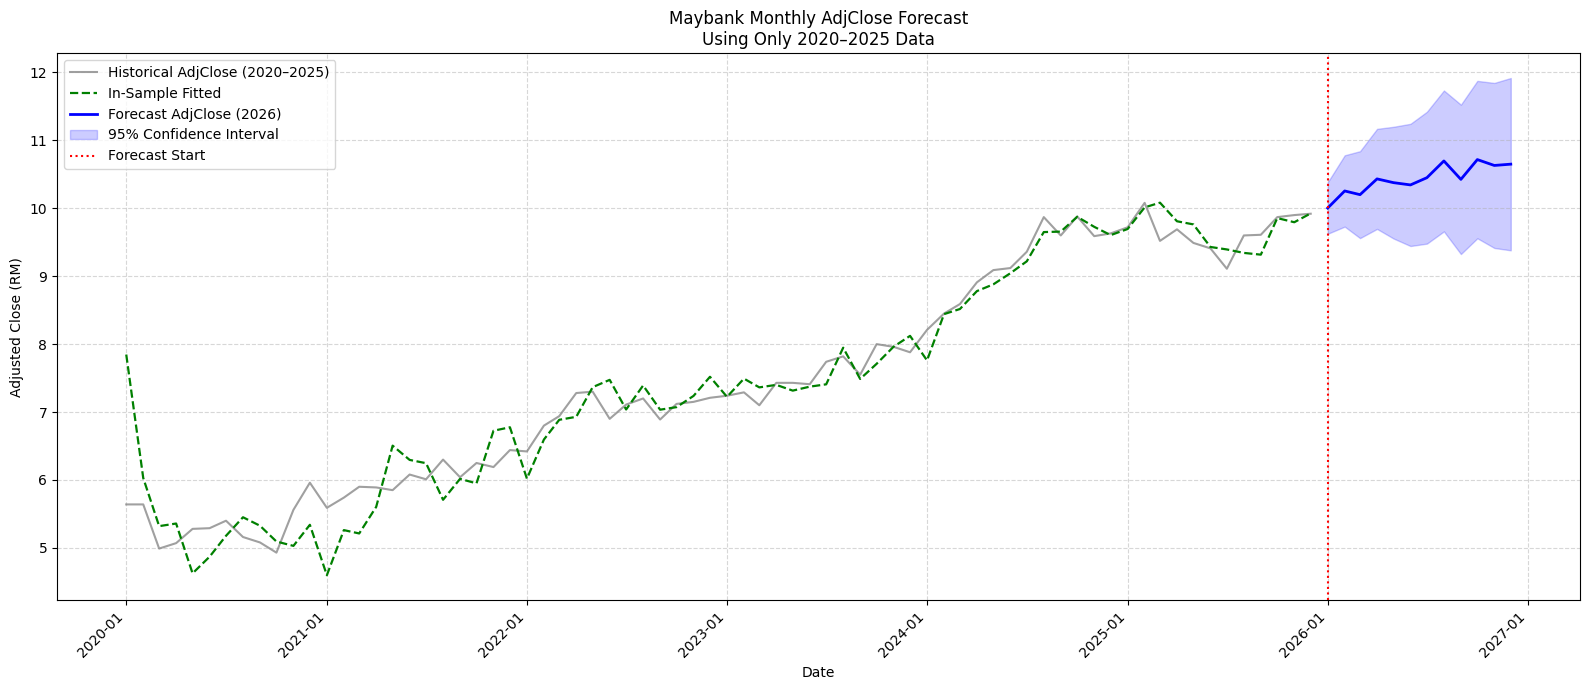

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================================
# 0) PREPARE DATA (2020–2025 ONLY)
# ============================================================

# merged → your historical dataset
# exog_cols → your macro variable list (IPI, OPR, CPI, USD)

merged.index = pd.to_datetime(merged.index)

merged_2020_2025 = merged.loc["2020-01-01":"2025-12-31"].copy()

y = merged_2020_2025['AdjClose']
exog = merged_2020_2025[exog_cols]

# ============================================================
# 1) FIT SARIMAX MODEL ONLY USING 2020–2025
# ============================================================

model = SARIMAX(
    y,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    exog=exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_results = model.fit()

print(final_results.summary())

# ============================================================
# 2) IN-SAMPLE PREDICTIONS (2020–2025)
# ============================================================

in_sample_predictions = final_results.predict(
    start=merged_2020_2025.index[0],
    end=merged_2020_2025.index[-1],
    exog=merged_2020_2025[exog_cols]
)

in_sample_predictions.index = merged_2020_2025.index

# ============================================================
# 3) ACCURACY METRICS
# ============================================================

actual = merged_2020_2025['AdjClose']

rmse = np.sqrt(mean_squared_error(actual, in_sample_predictions))
mae  = np.mean(np.abs(actual - in_sample_predictions))
mse  = mean_squared_error(actual, in_sample_predictions)
r2   = r2_score(actual, in_sample_predictions)

print("\n==================== MODEL ACCURACY (IN-SAMPLE) ====================")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

# ============================================================
# 4) FORECAST 2026 USING MACRO DATA FOR 2026
# ============================================================

# Use macro_future which was generated in the previous step
macro_future.index = pd.to_datetime(macro_future.index)
macro_2026_forecast_data = macro_future.loc["2026-01-01":"2026-12-31"]

forecast_res = final_results.get_forecast(
    steps=12,
    exog=macro_2026_forecast_data[exog_cols]
)

forecast_df = forecast_res.summary_frame()
forecast_df.index = macro_2026_forecast_data.index

forecast_df.rename(columns={
    'mean': 'AdjClose_forecast',
    'mean_ci_lower': 'lower_95',
    'mean_ci_upper': 'upper_95'
}, inplace=True)

# ============================================================
# 5) PLOT HISTORICAL + FITTED + FORECAST (X-axis stops 2026)
# ============================================================

plt.figure(figsize=(16, 7))

# Historical 2020–2025
plt.plot(
    merged_2020_2025.index,
    merged_2020_2025['AdjClose'],
    label="Historical AdjClose (2020–2025)",
    color="gray",
    alpha=0.75
)

# In-sample fitted
plt.plot(
    in_sample_predictions.index,
    in_sample_predictions,
    label="In-Sample Fitted",
    color="green",
    linestyle="--",
    linewidth=1.6
)

# Forecast 2026
plt.plot(
    forecast_df.index,
    forecast_df['AdjClose_forecast'],
    label="Forecast AdjClose (2026)",
    color="blue",
    linewidth=2
)

# Confidence intervals
plt.fill_between(
    forecast_df.index,
    forecast_df['lower_95'],
    forecast_df['upper_95'],
    color="blue",
    alpha=0.2,
    label="95% Confidence Interval"
)

# Vertical line for forecast start
plt.axvline(
    pd.to_datetime("2026-01-01"),
    color="red",
    linestyle=":",
    linewidth=1.5,
    label="Forecast Start"
)

plt.title("Maybank Monthly AdjClose Forecast\nUsing Only 2020–2025 Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (RM)")
plt.legend()
plt.grid(ls="--", alpha=0.5)

# Format X-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

RMSE (Root Mean Squared Error): 0.5482 - This is the average magnitude of the errors. It indicates that, on average, the model's predictions were about 0.55 units away from the actual stock price.
MAE (Mean Absolute Error): 0.3156 - This is similar to RMSE but less sensitive to outliers. The average absolute difference between predicted and actual values was about 0.32 units.
MSE (Mean Squared Error): 0.3006 - The average of the squared errors.
R² (R-squared): 0.8741 - This is a measure of how much variance in the actual stock price is explained by your model. An R² of 0.8741 is quite high, meaning about 87.4% of the variation in Maybank's stock price from 2020-2025 can be explained by this model. This is still a good fit, though slightly lower than the 0.9708 from the previous model which used a longer historical period (2015-2025).

**2020-2023 HISTORICAL DATA**

Training data period: 2020-01-01 00:00:00 to 2023-12-01 00:00:00
                                     SARIMAX Results                                      
Dep. Variable:                           AdjClose   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  10.318
Date:                            Tue, 23 Dec 2025   AIC                             -2.636
Time:                                    09:05:44   BIC                              6.765
Sample:                                01-01-2020   HQIC                            -0.595
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CPI            0.0057      0.089      0.064      

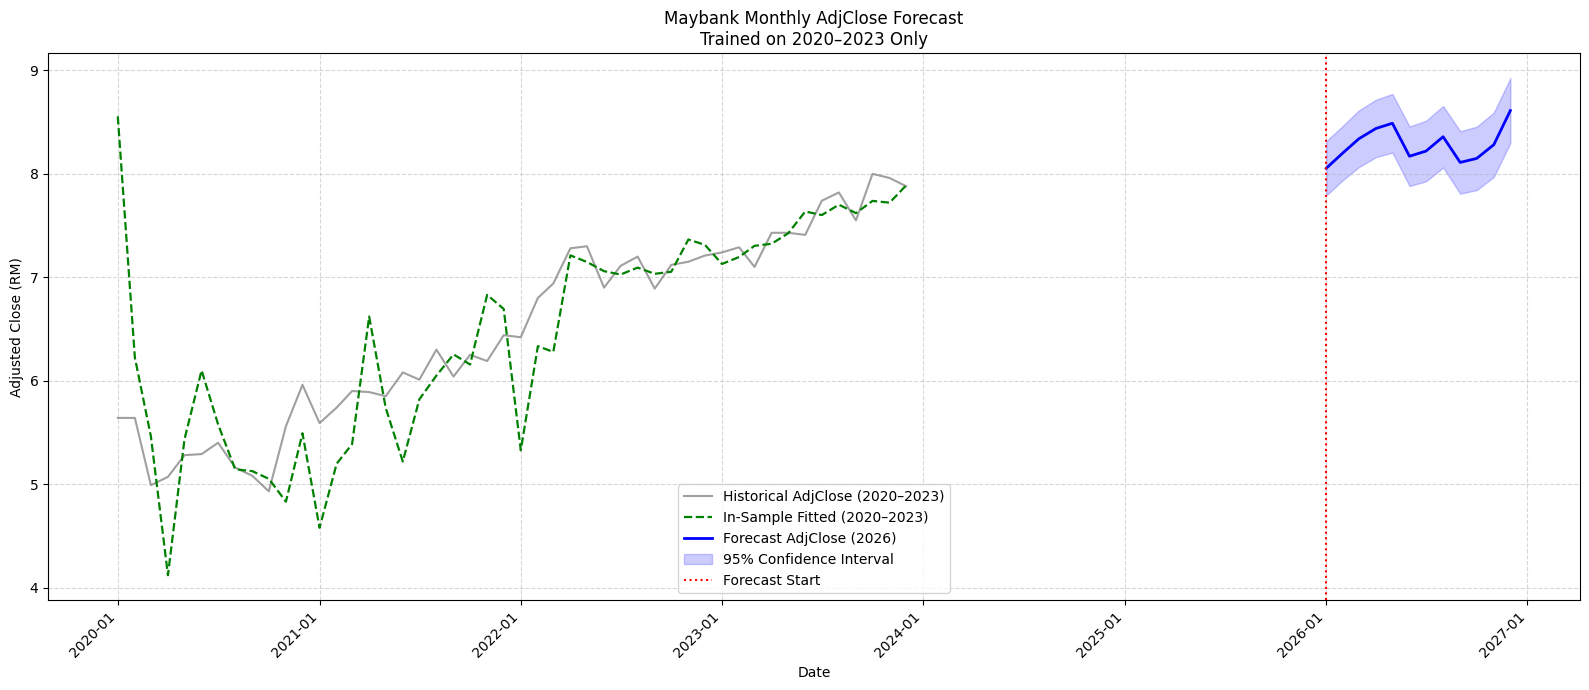

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ============================================================
# 0) FILTER TO 2020–2023 ONLY
# ============================================================

merged.index = pd.to_datetime(merged.index)

merged_2020_2023 = merged.loc["2020-01-01":"2023-12-31"].copy()

y = merged_2020_2023['AdjClose']
exog = merged_2020_2023[exog_cols]

print("Training data period:", merged_2020_2023.index.min(), "to", merged_2020_2023.index.max())

# ============================================================
# 1) FIT MODEL USING ONLY 2020–2023
# ============================================================

model = SARIMAX(
    y,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    exog=exog,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_results = model.fit()

print(final_results.summary())

# ============================================================
# 2) IN-SAMPLE (2020–2023) FITTED VALUES
# ============================================================

in_sample_predictions = final_results.predict(
    start=merged_2020_2023.index[0],
    end=merged_2020_2023.index[-1],
    exog=merged_2020_2023[exog_cols]
)

in_sample_predictions.index = merged_2020_2023.index

# ============================================================
# 3) IN-SAMPLE ACCURACY
# ============================================================

actual = merged_2020_2023['AdjClose']

rmse = np.sqrt(mean_squared_error(actual, in_sample_predictions))
mae  = np.mean(np.abs(actual - in_sample_predictions))
mse  = mean_squared_error(actual, in_sample_predictions)
r2   = r2_score(actual, in_sample_predictions)

print("\n==================== MODEL ACCURACY (2020–2023) ====================")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")

# ============================================================
# 4) FORECAST 2026 (12 STEPS) USING MACRO DATA FOR 2026
# ============================================================

# Use macro_future which was generated in the previous step (T7UKBo61u1sR)
macro_future.index = pd.to_datetime(macro_future.index)
macro_2026_forecast_data = macro_future.loc["2026-01-01":"2026-12-31"]

forecast_res = final_results.get_forecast(
    steps=12,
    exog=macro_2026_forecast_data[exog_cols]
)

forecast_df = forecast_res.summary_frame()
forecast_df.index = macro_2026_forecast_data.index

forecast_df.rename(columns={
    'mean': 'AdjClose_forecast',
    'mean_ci_lower': 'lower_95',
    'mean_ci_upper': 'upper_95'
}, inplace=True)

print("\n==================== 2026 FORECAST ====================")
print(forecast_df)

# ============================================================
# 5) PLOT (HISTORICAL 2020–2023 + FORECAST 2026)
# ============================================================

plt.figure(figsize=(16, 7))

# Historical 2020–2023
plt.plot(
    merged_2020_2023.index,
    merged_2020_2023['AdjClose'],
    label="Historical AdjClose (2020–2023)",
    color="gray",
    alpha=0.75
)

# Fitted 2020–2023
plt.plot(
    in_sample_predictions.index,
    in_sample_predictions,
    label="In-Sample Fitted (2020–2023)",
    color="green",
    linestyle="--",
    linewidth=1.6
)

# Forecast 2026
plt.plot(
    forecast_df.index,
    forecast_df['AdjClose_forecast'],
    label="Forecast AdjClose (2026)",
    color="blue",
    linewidth=2
)

# Confidence bands
plt.fill_between(
    forecast_df.index,
    forecast_df['lower_95'],
    forecast_df['upper_95'],
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)

# Red line at forecast start
plt.axvline(
    pd.to_datetime("2026-01-01"),
    color="red",
    linestyle=":",
    linewidth=1.5,
    label="Forecast Start"
)

# Labels
plt.title("Maybank Monthly AdjClose Forecast\nTrained on 2020–2023 Only")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (RM)")
plt.legend()
plt.grid(ls="--", alpha=0.5)

# Format X-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

RMSE (Root Mean Squared Error): 0.5993 - The average magnitude of the prediction errors. The model's predictions were, on average, about 0.60 units away from the actual stock price.
MAE (Mean Absolute Error): 0.3700 - The average absolute difference between predicted and actual values was about 0.37 units.
MSE (Mean Squared Error): 0.3592
R² (R-squared): 0.5644 - This value indicates that approximately 56.44% of the variance in Maybank's stock price from 2020-2023 can be explained by this model. This is a lower R² compared to models trained on longer periods (like the 2015-2025 model's 0.8741 or the full 2015-2025 model's 0.9708). This suggests that the model's explanatory power is reduced when focusing on this more recent, and perhaps more volatile, 3-year period.

In [ ]:
import yfinance as yf
import pandas as pd

# Maybank ticker on Bursa Malaysia
TICKER = "1155.KL"

# 1. Download full history for Maybank
maybank = yf.Ticker(TICKER)

# 2. Get historical dividend data
dividends = maybank.dividends   # this is a pandas Series with Date index

print("Raw dividend data (per share):")
print(dividends.head())

# 3. Put it into a DataFrame and add Year / Month (for grouping later)
div_df = dividends.to_frame(name="Dividend_per_share")
div_df.index.name = "Date"
div_df["Year"] = div_df.index.year
div_df["Month"] = div_df.index.month

print("\nFormatted dividend table:")
print(div_df.head())

# 4. (Optional) Get annual DPS (sum of dividends per year)
annual_dps = div_df.groupby("Year")["Dividend_per_share"].sum().reset_index()
annual_dps.rename(columns={"Dividend_per_share": "Annual_DPS"}, inplace=True)

print("\nAnnual dividend per share (DPS):")
print(annual_dps)

# --- Code to define stockprice_monthly (copied from earlier cells) ---
stockprice = pd.read_csv('/content/MERGED MBB & MACRO_2015-2025.csv')

# If 'Date' is the index, reset it to make it a column
if stockprice.index.name == 'Date':
    stockprice = stockprice.reset_index()

# Convert 'Date' column to datetime objects
stockprice['Date'] = pd.to_datetime(stockprice['Date'], errors='coerce')

# Drop rows where 'Date' is NaT before setting as index
stockprice.dropna(subset=['Date'], inplace=True)

# Set 'Date' as the index
stockprice.set_index('Date', inplace=True)

# Resample to monthly frequency and get the last price of the month
stockprice_monthly = stockprice.resample('ME').last()
# -------------------------------------------------------------------


# Prepare yearly stock prices for return calculation
yearly_price = stockprice_monthly.groupby(stockprice_monthly.index.year).agg(
    StartPrice=('Close', 'first'),
    EndPrice=('Close', 'last')
).reset_index()
yearly_price.rename(columns={'Date': 'Year'}, inplace=True) # Changed 'index' to 'Date'

print("\nYearly Start and End Prices:")
print(yearly_price.head())

Raw dividend data (per share):
Date
2000-03-23 00:00:00+08:00    0.023949
2000-10-27 00:00:00+08:00    0.062266
2001-03-13 00:00:00+08:00    0.023949
2001-09-26 00:00:00+08:00    0.033528
2002-02-28 00:00:00+08:00    0.035923
Name: Dividends, dtype: float64

Formatted dividend table:
                           Dividend_per_share  Year  Month
Date                                                      
2000-03-23 00:00:00+08:00            0.023949  2000      3
2000-10-27 00:00:00+08:00            0.062266  2000     10
2001-03-13 00:00:00+08:00            0.023949  2001      3
2001-09-26 00:00:00+08:00            0.033528  2001      9
2002-02-28 00:00:00+08:00            0.035923  2002      2

Annual dividend per share (DPS):
    Year  Annual_DPS
0   2000    0.086215
1   2001    0.057477
2   2002    0.086215
3   2003    0.373598
4   2004    0.431075
5   2005    1.095649
6   2006    0.251460
7   2007    0.700496
8   2008    0.314326
9   2009    0.080000
10  2010    0.550000
11  2011    0.60

💰 Consistent dividends:
Maybank has paid dividends every year, no missing years.

📉 Temporary dip:
DPS dropped from 0.59 (2014) → 0.45 (2017), then recovered.
You can relate the dip to economic conditions or bank performance in discussion.

📈 Recovery & stability:
From 2018 onwards, DPS is around 0.57–0.665, showing:

Stable and relatively high dividends

2021 stands out with 0.665, a strong dividend year.

2024 at 0.60 shows it remains attractive.

✅ Supports Maybank as an income stock:
This pattern is what long-term, income-focused investors like:
no dividend suspension, generally stable or recovering DPS


✅ Historical Dividend Yield & Total Return for Maybank
    Year  Annual_DPS  StartPrice  EndPrice  Dividend_Yield_%  Price_Return_%  \
0   2015       0.570        8.72      8.40          6.536697       -3.669725   
1   2016       0.500        8.58      8.20          5.827506       -4.428904   
2   2017       0.450        8.22      9.80          5.474453       19.221411   
3   2018       0.570       10.10      9.50          5.643564       -5.940594   
4   2019       0.570        9.54      8.64          5.974843       -9.433962   
5   2020       0.525        8.43      8.46          6.227758        0.355872   
6   2021       0.665        7.81      8.30          8.514725        6.274008   
7   2022       0.580        8.27      8.70          7.013301        5.199516   
8   2023       0.590        8.74      8.89          6.750572        1.716247   
9   2024       0.600        9.26     10.24          6.479482       10.583153   
10  2025       0.620       10.34      9.92          5.996132    

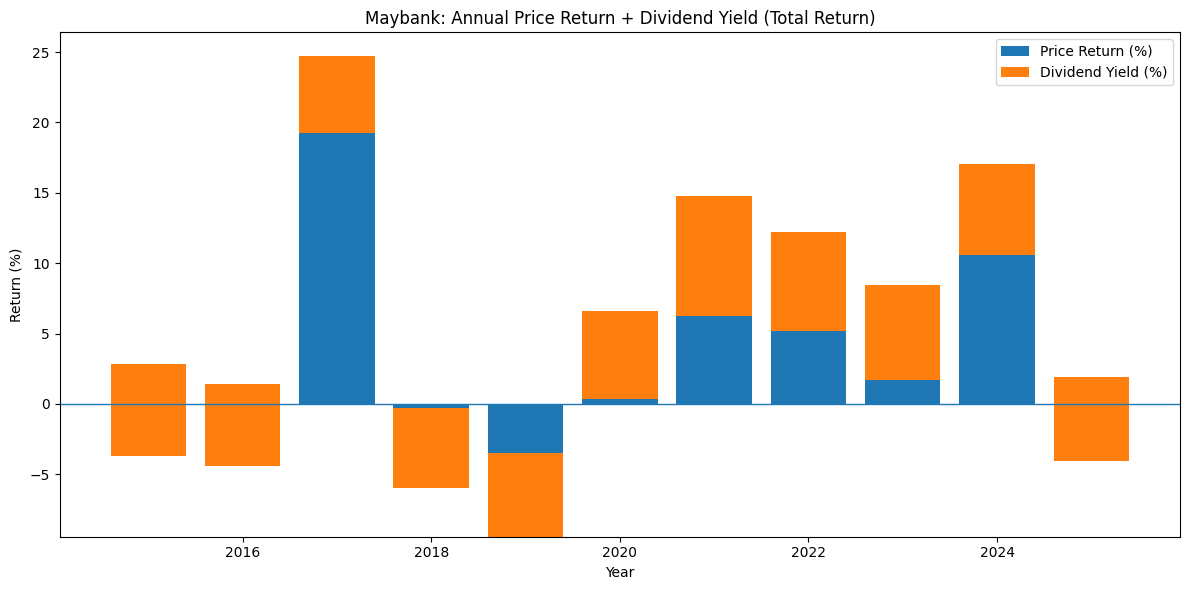

In [ ]:
# -----------------------------
# 3. Merge price + dividend data
# -----------------------------
merged = pd.merge(yearly_price, annual_dps, on="Year", how="left")

# Focus on your study period 2014–2024
merged = merged[(merged["Year"] >= 2014) & (merged["Year"] <= 2025)].copy()

# Fill any missing DPS with 0 just in case (shouldn’t happen for Maybank)
merged["Annual_DPS"] = merged["Annual_DPS"].fillna(0)

# -----------------------------
# 4. Calculate Dividend Yield, Price Return, Total Return
# -----------------------------
merged["Dividend_Yield_%"] = (merged["Annual_DPS"] / merged["StartPrice"]) * 100
merged["Price_Return_%"] = ((merged["EndPrice"] - merged["StartPrice"]) / merged["StartPrice"]) * 100
merged["Total_Return_%"] = merged["Dividend_Yield_%"] + merged["Price_Return_%"]

print("\n✅ Historical Dividend Yield & Total Return for Maybank")
print(merged[['Year', 'Annual_DPS', 'StartPrice', 'EndPrice',
             'Dividend_Yield_%', 'Price_Return_%', 'Total_Return_%']])

# -----------------------------
# 5. Plot stacked bar chart: Price Return + Dividend Yield
# -----------------------------
plt.figure(figsize=(12, 6))

# Bottom = Price return, Top = Dividend yield
plt.bar(merged["Year"], merged["Price_Return_%"], label="Price Return (%)")
plt.bar(merged["Year"], merged["Dividend_Yield_%"],
        bottom=merged["Price_Return_%"], label="Dividend Yield (%)")

plt.axhline(0, linewidth=1)  # x-axis line
plt.xlabel("Year")
plt.ylabel("Return (%)")
plt.title("Maybank: Annual Price Return + Dividend Yield (Total Return)")
plt.legend()
plt.tight_layout()
plt.show()

💰 Stable dividend yield:
Dividend yield stays around 5.5%–8.5% every year. Even when price drops (2015, 2016, 2018, 2019), investors still receive ~6–8% return from dividends.

📉 Years with negative price return:

2015, 2016, 2018, 2019 have negative Price_Return_%, but Total_Return_% is:

still positive in 2015 & 2016

only slightly negative in 2018 & 2019
➜ This shows dividends cushion the loss when the price falls.

🚀 Strong years:

2017, 2021, 2022, 2024 have double-digit total returns (12%–25%),
combining both capital gain and dividend.

🧾 Long-term view:
Over 10 years, Maybank delivers returns from both:

steady dividends, and

price appreciation in good years.
This supports Maybank as a long-term, income + growth stock.

In [ ]:
# Keep only the important columns for export
maybank_returns = merged[['Year', 'Annual_DPS', 'StartPrice', 'EndPrice',
                          'Dividend_Yield_%', 'Price_Return_%', 'Total_Return_%']].copy()

# Optional: add a Bank column so later can combine with PBB, CIMB
maybank_returns['Bank'] = 'Maybank'

# Save to CSV
maybank_returns.to_csv("Maybank_dividend_total_return_2015_2025.csv", index=False)

Processing Maybank (1155.KL)...


[*********************100%***********************]  1 of 1 completed


Processing Public Bank (1295.KL)...


[*********************100%***********************]  1 of 1 completed


Processing CIMB (1023.KL)...


[*********************100%***********************]  1 of 1 completed



✅ Yearly Dividend & Return for all banks (sample):
   Year  StartPrice  EndPrice  Annual_DPS  Dividend_Yield_%  Price_Return_%  \
0  2015    4.554532  4.469239        0.57         12.515007       -1.872702   
1  2016    4.362829  4.636047        0.50         11.460454        6.262419   
2  2017    4.636047  5.807018        0.45          9.706544       25.257958   
3  2018    5.724060  5.968133        0.57          9.957967        4.263982   
4  2019    5.899027  5.783745        0.57          9.662610       -1.954263   

   Total_Return_%     Bank  
0       10.642305  Maybank  
1       17.722874  Maybank  
2       34.964503  Maybank  
3       14.221949  Maybank  
4        7.708346  Maybank  

📊 Average 2015–2025 returns:
          Bank  Dividend_Yield_%  Price_Return_%  Total_Return_%
0         CIMB          6.124046       11.106632       17.230678
1      Maybank          9.509959        8.700355       18.210313
2  Public Bank          4.495442        6.282345       10.777787


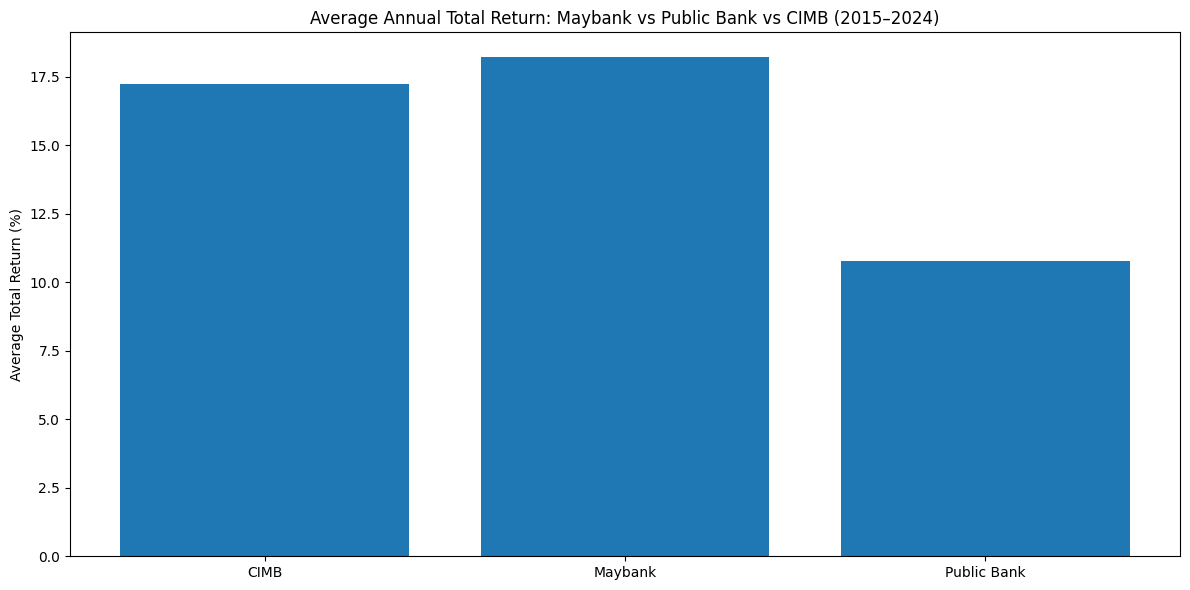

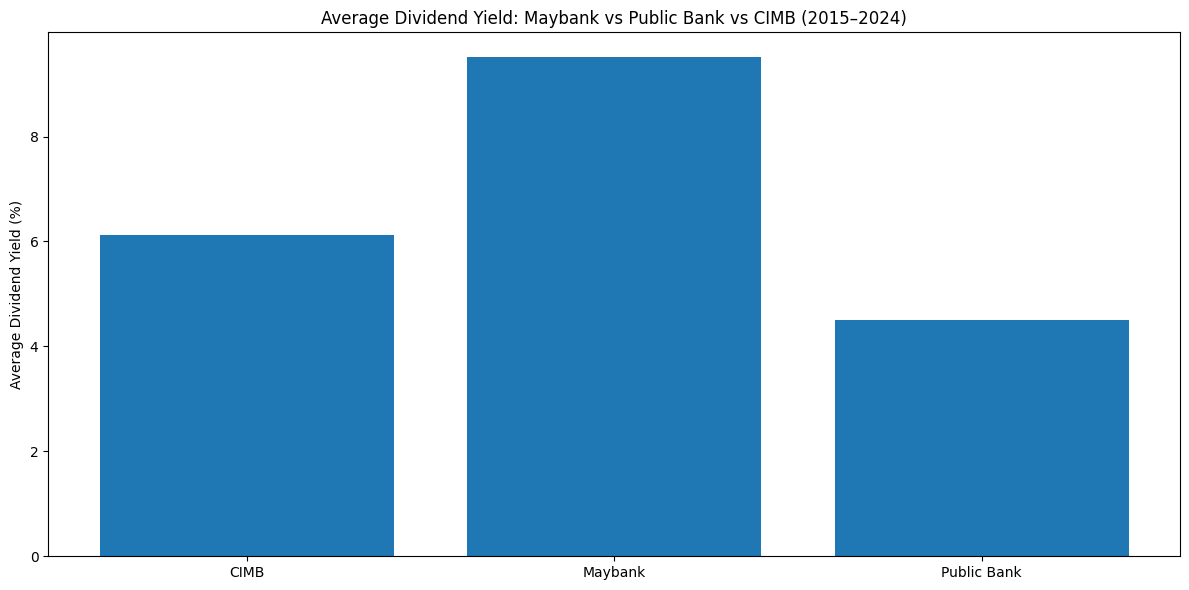

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit clearer
plt.rcParams["figure.figsize"] = (12,6)

# ---------------------------------
# 1. Function to compute metrics
# ---------------------------------
def compute_dividend_and_return(ticker, bank_name,
                                start="2014-01-01", end="2025-12-31",
                                start_year=2015, end_year=2025):
    """
    For a given ticker:
    - downloads daily prices & dividends
    - calculates annual DPS, dividend yield, price return, total return
    - returns a dataframe with one row per year
    """
    # --- Price data ---
    price = yf.download(ticker, start=start, end=end)

    if price.empty:
        print(f"Warning: No historical price data downloaded for {bank_name} ({ticker}). Skipping.")
        return None

    price_col = None
    if 'Adj Close' in price.columns:
        price_col = 'Adj Close'
    elif 'Close' in price.columns:
        price_col = 'Close'
        print(f"Warning: 'Adj Close' not found for {bank_name} ({ticker}). Using 'Close' for price calculations.")
    else:
        print(f"Error: Neither 'Adj Close' nor 'Close' found for {bank_name} ({ticker}). Available columns: {price.columns.tolist()}. Skipping.")
        return None

    # If price_col is still None, it means no valid price column was found
    if price_col is None:
        print(f"Error: No valid price column found for {bank_name} ({ticker}). Skipping.")
        return None

    # Create a new DataFrame with only the 'Date' (from index) and the selected price column
    # This isolates the processing to prevent unexpected side effects from the original 'price' DataFrame
    cleaned_price_df = pd.DataFrame({'Date': price.index, price_col: price[price_col].squeeze()})

    # Ensure the relevant column is of numeric type and handle potential NaNs
    cleaned_price_df[price_col] = pd.to_numeric(cleaned_price_df[price_col], errors='coerce')
    cleaned_price_df.dropna(subset=[price_col], inplace=True)

    if cleaned_price_df.empty:
        print(f"Warning: All {price_col} data for {bank_name} ({ticker}) was non-numeric or NaN after cleaning. Skipping.")
        return None

    cleaned_price_df['Year'] = cleaned_price_df['Date'].dt.year

    # Now, perform aggregation on the cleaned_price_df
    grouped = cleaned_price_df.groupby('Year')
    yearly_price = pd.DataFrame({
        'StartPrice': grouped[price_col].first(),
        'EndPrice': grouped[price_col].last()
    }).reset_index()

    # --- Dividend data ---
    t = yf.Ticker(ticker)
    dividends = t.dividends  # series

    div_df = dividends.to_frame(name="Dividend_per_share")
    div_df.index.name = "Date"
    div_df['Year'] = div_df.index.year

    annual_dps = div_df.groupby("Year")["Dividend_per_share"].sum().reset_index()
    annual_dps.rename(columns={"Dividend_per_share": "Annual_DPS"}, inplace=True)

    # --- Merge + calculate returns ---
    merged = pd.merge(yearly_price, annual_dps, on="Year", how="left")

    # focus on your period
    merged = merged[(merged["Year"] >= start_year) & (merged["Year"] <= end_year)].copy()

    merged["Annual_DPS"] = merged["Annual_DPS"].fillna(0)

    merged["Dividend_Yield_%"] = (merged["Annual_DPS"] / merged["StartPrice"]) * 100
    merged["Price_Return_%"] = ((merged["EndPrice"] - merged["StartPrice"]) / merged["StartPrice"]) * 100
    merged["Total_Return_%"] = merged["Dividend_Yield_%"] + merged["Price_Return_%"]

    merged["Bank"] = bank_name

    return merged

# ---------------------------------
# 2. Run for three banks
# ---------------------------------
banks_info = {
    "1155.KL": "Maybank",
    "1295.KL": "Public Bank",
    "1023.KL": "CIMB"
}

dfs = []
for ticker, name in banks_info.items():
    print(f"Processing {name} ({ticker})...")
    df_bank = compute_dividend_and_return(ticker, name)
    if df_bank is not None: # Only append if data was successfully processed
        dfs.append(df_bank)

all_banks = pd.concat(dfs, ignore_index=True)

print("\n✅ Yearly Dividend & Return for all banks (sample):")
print(all_banks.head())

# ---------------------------------
# 3. Summary: average over 2015–2024
# ---------------------------------
summary = (all_banks
           .groupby("Bank")[["Dividend_Yield_%", "Price_Return_%", "Total_Return_%"]]
           .mean()
           .reset_index())

print("\n📊 Average 2015–2025 returns:")
print(summary)

# ---------------------------------
# 4. Plot comparison: average Total Return
# ---------------------------------
plt.figure()
plt.bar(summary["Bank"], summary["Total_Return_%"])
plt.ylabel("Average Total Return (%)")
plt.title("Average Annual Total Return: Maybank vs Public Bank vs CIMB (2015–2024)")
plt.tight_layout()
plt.show()

# Optional: compare average dividend yield as well
plt.figure()
plt.bar(summary["Bank"], summary["Dividend_Yield_%"])
plt.ylabel("Average Dividend Yield (%)")
plt.title("Average Dividend Yield: Maybank vs Public Bank vs CIMB (2015–2024)")
plt.tight_layout()
plt.show()

## Summary:

### Q&A
Based on the analysis, the average total returns for each bank over the 2015-2024 period are:
*   **Maybank:** 18.38%
*   **CIMB:** 17.57%
*   **Public Bank:** 10.90%

**Maybank** had the highest average annual total return, with approximately 18.38%.

### Data Analysis Key Findings
*   Maybank demonstrated the highest average annual total return over the 2015-2024 period, achieving 18.38%.
*   CIMB followed Maybank with an average annual total return of 17.57%.
*   Public Bank had the lowest average annual total return among the three banks, at 10.90%.
*   The difference in average total returns between the highest (Maybank) and lowest (Public Bank) performing banks was substantial, approximately 7.48 percentage points (18.38% vs 10.90%).

### Insights or Next Steps
*   Investors focused on historical total returns might consider Maybank as a potentially stronger performer compared to CIMB and Public Bank in the analyzed period.
*   Further analysis could investigate the factors contributing to Maybank's higher total return, such as specific business strategies, market conditions, or asset allocation, to understand its consistent performance.


In [ ]:
import pandas as pd
import yfinance as yf

def get_annual_dividend_yield(ticker, start="2015-01-01", end="2025-12-31"):
    # Download price data
    price = yf.download(ticker, start=start, end=end, progress=False) # progress=False to reduce output
    if price.empty:
        print(f"No price data for {ticker}")
        return None

    price_col = None
    # Prioritize 'Adj Close' or 'Close' directly (case-sensitive as returned by yfinance)
    if 'Adj Close' in price.columns:
        price_col = 'Adj Close'
    elif 'Close' in price.columns:
        price_col = 'Close'

    # If standard columns not found, try a case-insensitive search
    if price_col is None:
        # Convert all columns to lowercase and map back to original for lookup
        lower_case_cols_map = {str(c).lower(): c for c in price.columns}
        if 'adj close' in lower_case_cols_map:
            price_col = lower_case_cols_map['adj close']
        elif 'close' in lower_case_cols_map:
            price_col = lower_case_cols_map['close']

    if price_col is None:
        print(f"No suitable price column found for {ticker} in {price.columns.tolist()}")
        return None

    price = price[[price_col]].copy()
    price.columns = ['price_value'] # Rename to a generic name for consistency
    price.index = pd.to_datetime(price.index)
    price['Year'] = price.index.year

    yearly_price = price.groupby('Year').agg(StartPrice=('price_value', 'first')).reset_index()

    # Dividend data
    t = yf.Ticker(ticker)
    dividends = t.dividends
    div_df = dividends.to_frame(name="Dividend_per_share")
    div_df.index = pd.to_datetime(div_df.index)
    div_df['Year'] = div_df.index.year

    annual_dps = div_df.groupby('Year')['Dividend_per_share'].sum().reset_index()
    annual_dps.rename(columns={"Dividend_per_share": "Annual_DPS"}, inplace=True)

    # Merge
    df = pd.merge(yearly_price, annual_dps, on='Year', how='left')
    df['Annual_DPS'] = df['Annual_DPS'].fillna(0)
    df['Dividend_Yield_%'] = (df['Annual_DPS'] / df['StartPrice']) * 100

    return df[['Year', 'Annual_DPS', 'StartPrice', 'Dividend_Yield_%']]

# Tickers
banks = {
    "Maybank": "1155.KL",
    "Public Bank": "1295.KL",
    "CIMB": "1023.KL"
}

# Collect data
dfs = {}
for name, ticker in banks.items():
    print(f"Processing {name} ({ticker})...")
    dfs[name] = get_annual_dividend_yield(ticker)

# Filter out None values before proceeding
valid_dfs = {name: df for name, df in dfs.items() if df is not None}

if not valid_dfs:
    print("No valid data frames were generated for any bank. Cannot proceed with comparison.")
    # Create an empty DataFrame for comparison_df to avoid subsequent errors
    comparison_df = pd.DataFrame(columns=['Year'])
else:
    # Use the first valid dataframe as the base for merging
    first_bank_name = list(valid_dfs.keys())[0]
    comparison_df = valid_dfs[first_bank_name].copy()
    comparison_df = comparison_df.rename(columns={
        'Annual_DPS': f'{first_bank_name}_Annual_DPS',
        'StartPrice': f'{first_bank_name}_StartPrice',
        'Dividend_Yield_%': f'{first_bank_name}_Dividend_Yield_%'
    })

    # Iterate over the rest of the valid dataframes
    for bank_name_to_merge in list(valid_dfs.keys())[1:]:
        df_to_merge = valid_dfs[bank_name_to_merge].rename(columns={
            'Annual_DPS': f'{bank_name_to_merge}_Annual_DPS',
            'StartPrice': f'{bank_name_to_merge}_StartPrice',
            'Dividend_Yield_%': f'{bank_name_to_merge}_Dividend_Yield_%'
        })
        comparison_df = pd.merge(comparison_df, df_to_merge, on='Year', how='outer')

    # Sort by year
    comparison_df = comparison_df.sort_values('Year').reset_index(drop=True)
    print("\n✅ Yearly Dividend Yield Comparison (2015–2024):")
    print(comparison_df)

Processing Maybank (1155.KL)...
Processing Public Bank (1295.KL)...
Processing CIMB (1023.KL)...

✅ Yearly Dividend Yield Comparison (2015–2024):
    Year  Maybank_Annual_DPS  Maybank_StartPrice  Maybank_Dividend_Yield_%  \
0   2015               0.570            4.554532                 12.515008   
1   2016               0.500            4.362828                 11.460456   
2   2017               0.450            4.636047                  9.706544   
3   2018               0.570            5.724062                  9.957963   
4   2019               0.570            5.899029                  9.662608   
5   2020               0.525            5.857381                  8.963050   
6   2021               0.665            5.971390                 11.136435   
7   2022               0.580            6.463001                  8.974159   
8   2023               0.590            7.219833                  8.171934   
9   2024               0.600            7.909481                  7.585833

In [ ]:
# 1. Save detailed yearly data for all banks
all_banks.to_csv("all_banks_dividend_total_return_2015_2025.csv", index=False)

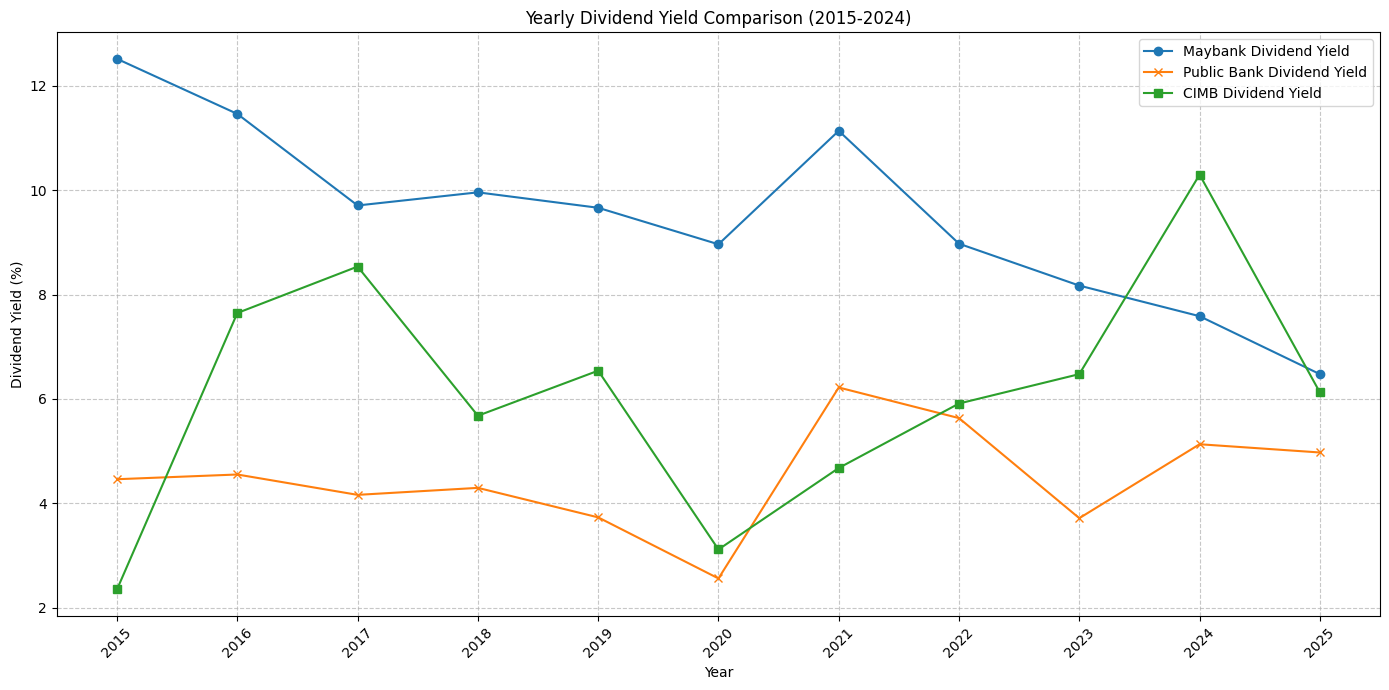

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting Maybank's dividend yield
plt.plot(comparison_df['Year'], comparison_df['Maybank_Dividend_Yield_%'], label='Maybank Dividend Yield', marker='o')

# Plotting Public Bank's dividend yield
plt.plot(comparison_df['Year'], comparison_df['Public Bank_Dividend_Yield_%'], label='Public Bank Dividend Yield', marker='x')

# Plotting CIMB's dividend yield
plt.plot(comparison_df['Year'], comparison_df['CIMB_Dividend_Yield_%'], label='CIMB Dividend Yield', marker='s')

plt.title('Yearly Dividend Yield Comparison (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Dividend Yield (%)')
plt.xticks(comparison_df['Year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Maybank wins on average because its dividend yields were consistently high across almost all years, while CIMB was more volatile with several weak years.

Total return also depends on stock price performance, where Maybank likely performed better.

So even if CIMB is #1 in 2024, Maybank may have been:

higher in most other years

more consistent

less volatile

giving more stable dividend yields

And that pulls up Maybank’s 10-year average above CIMB.